In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch import nn, optim

In [2]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [3]:
# Create training and test dataloaders

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize the Data

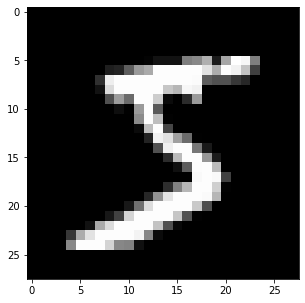

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
## Linear Autoencoder

Let us train an autoencoder with these images by flattening them into 784 length vectors. The images from this dataset are already normalized such that the values are between 0 and 1. Let's start by building a simple autoencoder. The encoder and decoder should be made of **one linear layer**. The units that connect the encoder and decoder will be the _compressed representation_.

Since the images are normalized between 0 and 1, we need to use a **sigmoid activation on the output layer** to get values that match this input value range.

<img src='simple_autoencoder.png' width=50% />


#### Below are the steps to create Linear autoencoder
>```
• The input images will be flattened into 784 length vectors. The targets are same as the inputs.
• The encoder and decoder will be made of two linear layers, each.
• The depth dimensions will change as follows: 784 inputs > **encoding_dim** > 784 outputs.
• All layers will have ReLu activations applied except for the final output layer, which has a sigmoid activation.
```

**The compressed representation will be a vector with dimension `encoding_dim=32`.**

In [5]:
def lin_model(encoding_dim):
    model = nn.Sequential(nn.Linear(28*28, encoding_dim),
                         nn.ReLU(),
                         nn.Linear(encoding_dim, 28*28),
                         nn.Sigmoid())
    return model


model = lin_model(encoding_dim = 32)
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=784, bias=True)
  (3): Sigmoid()
)


---
## Training

Let us train the network. We are not interested in validation here, so we'll just monitor the training loss and the test loss.

We are not concerned with labels in this case, just images, which we can get from the `train_loader`. Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing _quantities_ rather than probabilistic values. So, in this case, we'll use `MSELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

Otherwise, this is pretty straightfoward training with PyTorch. We flatten our images, pass them into the autoencoder, and record the training loss as we go.

In [6]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(len(images), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.673825
Epoch: 2 	Training Loss: 0.350858
Epoch: 3 	Training Loss: 0.307276
Epoch: 4 	Training Loss: 0.298204
Epoch: 5 	Training Loss: 0.294514
Epoch: 6 	Training Loss: 0.292412
Epoch: 7 	Training Loss: 0.291068
Epoch: 8 	Training Loss: 0.290033
Epoch: 9 	Training Loss: 0.289200
Epoch: 10 	Training Loss: 0.288531
Epoch: 11 	Training Loss: 0.287916
Epoch: 12 	Training Loss: 0.287342
Epoch: 13 	Training Loss: 0.286821
Epoch: 14 	Training Loss: 0.286227
Epoch: 15 	Training Loss: 0.285732
Epoch: 16 	Training Loss: 0.285304
Epoch: 17 	Training Loss: 0.284902
Epoch: 18 	Training Loss: 0.284520
Epoch: 19 	Training Loss: 0.284148
Epoch: 20 	Training Loss: 0.283790


## Checking out the results

Below let us plot some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

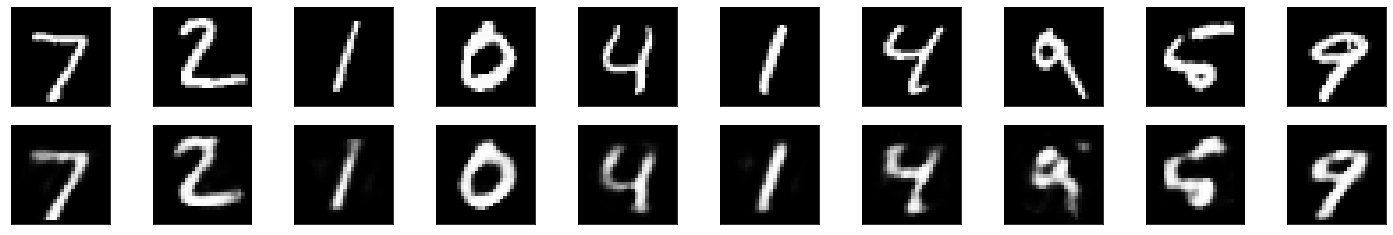

In [8]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images_flatten = images.view(len(images), -1)
# get sample outputs
output = model(images_flatten)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)